In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import time
import scipy.linalg as scilinalg
import seaborn as sns
from scipy.stats import ortho_group
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import scipy.io

import multiprocessing as mp
from joblib import Parallel, delayed
from utils import *
from conf_simu import *

np.random.seed(1347)

In [65]:
def simu_sales(alpha,het,M_ob,pr,rk,kap,plot=False,full_exp=False):
    sigma_true = False
    d1,d2 = M_ob.shape[0],M_ob.shape[1]
    P = pr*np.ones((d1,d2))
    if het=='rank1':
        m = 200
        P[:,4:d2:5] = pr/3
        P[np.random.choice(P.shape[0],m),:] = pr/3
    S = np.less(np.random.rand(d1,d2), P)
    A = M_ob*S
    return cfmc_simu(alpha,rk,A,M_ob,P,het,kap,sigma_true,plot,full_exp)


In [66]:
data_ = 'sale'
if data_ == 'temp':
    mat = scipy.io.loadmat('../weather/2018.mat')
    M_sale = np.array(mat['M'])/10
else:
    M_ob = pd.read_csv('../sales/sales.csv', sep=',', header=None, skiprows=1)
    M_ob = M_ob.drop([0], axis=1)
    M_ = (M_ob.to_numpy()/1000)
    n_zeros = np.mean(M_==0, axis=0)
    col_id = (n_zeros < 0.5)
    M_sale = M_[:,col_id]
    M_sale[M_sale==0] = np.mean(M_sale)

(1115, 780)


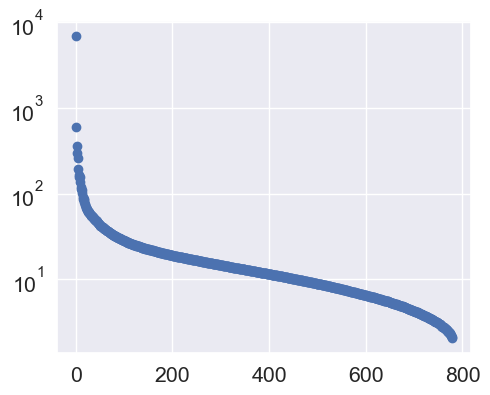

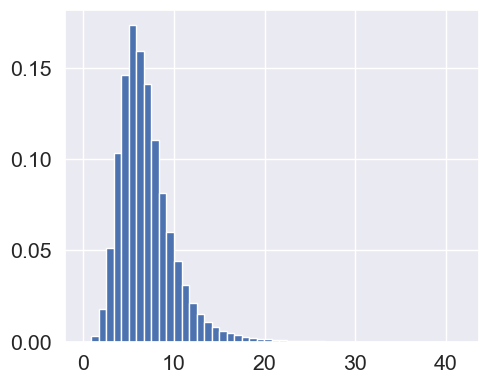

In [67]:
u, s, vh = np.linalg.svd(M_sale)

print(M_sale.shape)

fig, ax = plt.subplots(figsize=(5,4))
fig.tight_layout(pad=0.6)
sns.set(font_scale = 1.4)

ax.plot(s, 'bo')
ax.set_yscale('log')

plot_dir = '../plots/sv_sale.pdf'
plt.savefig(plot_dir, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,4))
fig.tight_layout(pad=0.6)
sns.set(font_scale = 1.4)

ax.hist(M_sale.ravel(), bins=50, density=True)
plot_dir = '../plots/hist_sale.pdf'
plt.savefig(plot_dir, bbox_inches='tight')

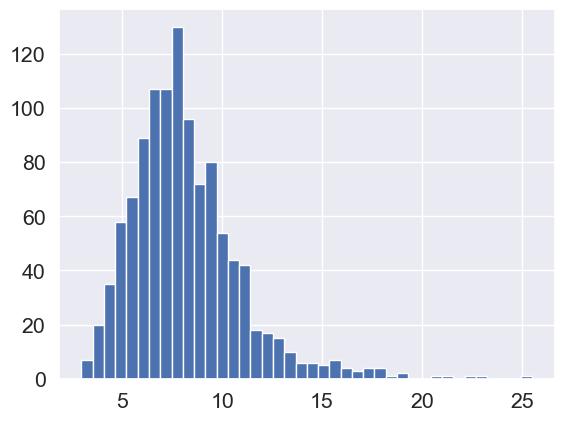

In [59]:
plt.hist(M_sale[:,3],40)
plt.show()

1.6448536269514722
(0.9009565180443743, 0.9239334461393112, 1.9484, 2.1397)


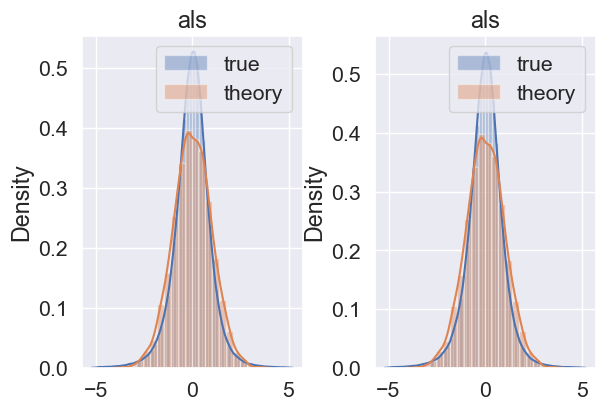

In [41]:
alpha = 0.1
print(norm.ppf(1-alpha/2))
pr = 0.6
rk = 10
kap = 1
res = simu_sales(alpha,M_sale,pr,rk,kap,plot=True)
print(res)

55
65
55
65


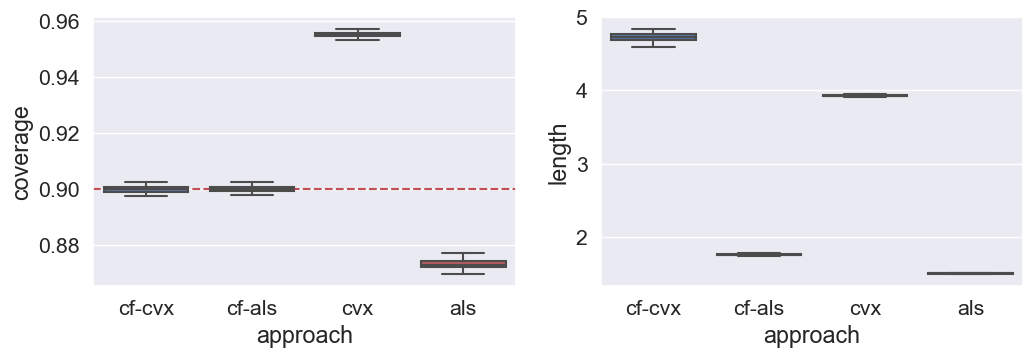

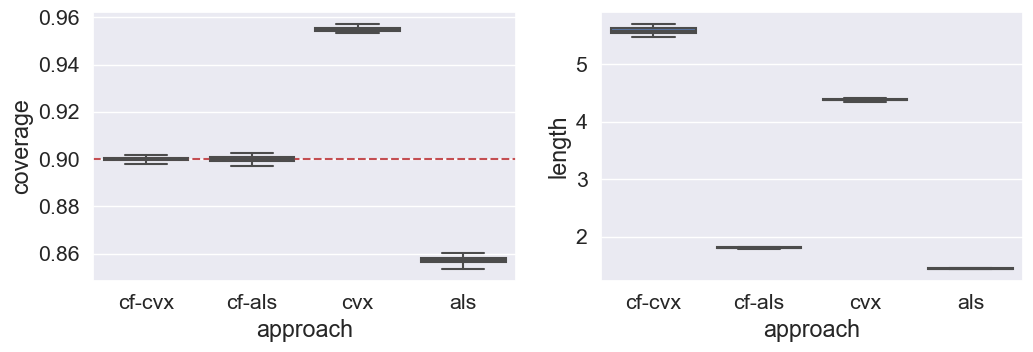

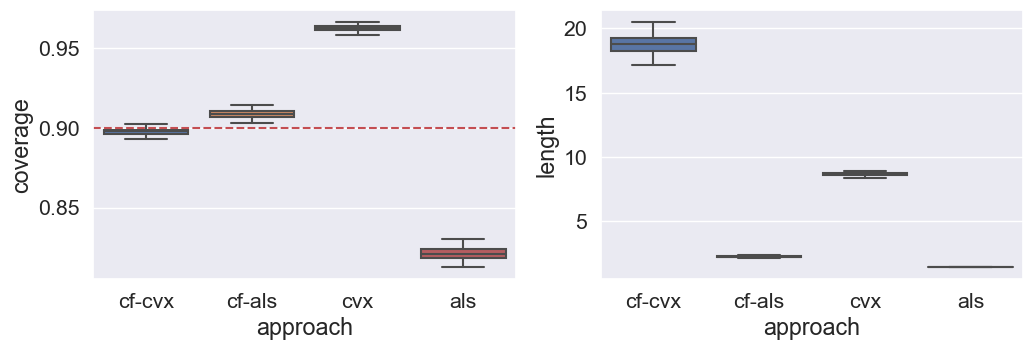

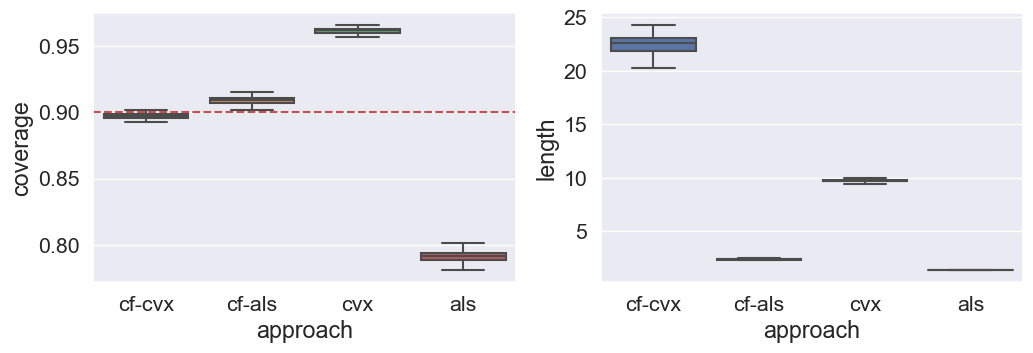

In [84]:
# repeated
# remember to disable plotting
repN = 100
num_cores = mp.cpu_count()
base1 = 'cvx'
base2 = 'als'
kap = 1
alpha = 0.1
full_exp = True
if full_exp:
#     rk_seq = [5,15,25,35,45]
    rk_seq = [55,65]
else:
    rk_seq = [5,10,15,20,25,30,35,40,45,50,55,60]

for pr in [0.8]:
    for het in ['homo','rank1']:
        for rk in rk_seq:
            print(rk)
            if __name__ == "__main__":
                results = Parallel(n_jobs=num_cores)(delayed(simu_sales)(alpha,het,M_sale,pr,rk,kap,plot=False,full_exp=full_exp) for i in range(repN))
            results = np.array(results)
            
            if full_exp:
                res_mat = results.reshape(repN,8)
                cov_rt_cf_cvx = res_mat[:,0]
                cov_rt_cf_als = res_mat[:,1]
                cov_rt_cvx = res_mat[:,2]
                cov_rt_als = res_mat[:,3]
                cov_ = np.hstack((cov_rt_cf_cvx, cov_rt_cf_als))
                cov_ = np.hstack((cov_,cov_rt_cvx))
                cov_ = np.hstack((cov_,cov_rt_als))
                len_ave_cf_cvx = res_mat[:,4]
                len_ave_cf_als = res_mat[:,5]
                len_ave_cvx = res_mat[:,6]
                len_ave_als = res_mat[:,7]
                len_ = np.hstack((len_ave_cf_cvx, len_ave_cf_als))
                len_ = np.hstack((len_,len_ave_cvx))
                len_ = np.hstack((len_,len_ave_als))

                label1 = 'cf-'+base1
                label2 = 'cf-'+base2
                label3 = 'cvx'
                label4 = 'als'
                nam_ = [label1]*repN + [label2]*repN + [label3]*repN + [label4]*repN
                cov_df = pd.DataFrame(cov_, columns=['coverage'])
                len_df = pd.DataFrame(len_, columns=['length'])
                cov_df['approach'] = nam_
                len_df['approach'] = nam_
            else:
                res_mat = results.reshape(repN,4)
                cov_rt_cf_als = res_mat[:,0]
                cov_rt_als = res_mat[:,1]
                cov_ = np.hstack((cov_rt_cf_als,cov_rt_als))
                len_ave_cf_als = res_mat[:,2]
                len_ave_als = res_mat[:,3]
                len_ = np.hstack((len_ave_cf_als,len_ave_als))

                label1 = 'cf-'+base2
                label2 = 'als'
                nam_ = [label1]*repN + [label2]*repN
                cov_df = pd.DataFrame(cov_, columns=['coverage'])
                len_df = pd.DataFrame(len_, columns=['length'])
                cov_df['approach'] = nam_
                len_df['approach'] = nam_

            file_dir1 = '../results/'+data_+'_cov_'+str(alpha)+'_'+het+'_'+str(pr)+'_'+str(rk)+'_'+str(full_exp)+'.csv'
            file_dir2 = '../results/'+data_+'_len_'+str(alpha)+'_'+het+'_'+str(pr)+'_'+str(rk)+'_'+str(full_exp)+'.csv'
            cov_df.to_csv(file_dir1, index=False)
            len_df.to_csv(file_dir2, index=False)

            fig, ax = plt.subplots(ncols=2,figsize=(12,3.5))

            sns.boxplot(ax=ax[0], data=cov_df, y="coverage", x="approach",showfliers = False)
            ax[0].axhline(y = 1-alpha, color = 'r', linestyle = '--')
            # ax[0].set_title('$d_1=d_2=$'+str(d1)+', pr='+str(pr)+', sd='+str(sd)+', sd_ptb='+str(sd_perturb))
            # ax[0].set_title('$d_1=d_2=$'+str(d1)+', pr='+str(pr)+', sd='+str(sd)+', tail='+tail)

            sns.boxplot(ax=ax[1], data=len_df, y="length", x="approach",showfliers = False)
            # ax[1].set_ylim(1,2)

            plot_dir = '../plots/'+data_+'_'+str(alpha)+'_'+het+'_'+str(pr)+'_'+str(rk)+'_'+str(full_exp)+'.pdf'
            plt.savefig(plot_dir, bbox_inches='tight')



In [ ]:
# alpha = 0.1
# repN = 100
# pr = 0.8
# data_ = 'sales'


# label1 = 'cf-'+base1
# label2 = 'cf-'+base2
# label3 = 'cvx'
# label4 = 'als'
# nam_ = [label1]*repN + [label2]*repN + [label3]*repN + [label4]*repN #+ [label5]*repN + [label6]*repN

# file_dir1 = '../results/'+data_+'_cov_'+str(alpha)+'_'+str(pr)+'_'+str(rk)+'.csv'
# file_dir2 = '../results/'+data_+'_len_'+str(alpha)+'_'+str(pr)+'_'+str(rk)+'.csv'
# cov_df = pd.read_csv(file_dir1)
# len_df = pd.read_csv(file_dir2)

# cov_df['approach'] = nam_
# len_df['approach'] = nam_

# fig, ax = plt.subplots(ncols=2,figsize=(10,4))
# fig.tight_layout(pad=0.6)
# sns.set(font_scale = 1.4)

# sns.boxplot(ax=ax[0], data=cov_df, y="coverage", x="approach",showfliers = False)
# ax[0].axhline(y = 1-alpha, color = 'r', linestyle = '--')
# # ax[0].set_title('$d_1=d_2=$'+str(d1)+', pr='+str(pr)+', sd='+str(sd)+', sd_ptb='+str(sd_perturb))
# # ax[0].set_title('$d_1=d_2=$'+str(d1)+', pr='+str(pr)+', sd='+str(sd)+', tail='+tail)

# sns.boxplot(ax=ax[1], data=len_df, y="length", x="approach",showfliers = False)
# # ax[1].set_ylim(1,2)

# plot_dir = '../plots/'+data_+'_'+str(alpha)+'_'+str(pr)+'_'+str(rk)+'.pdf'
# plt.savefig(plot_dir, bbox_inches='tight')

# Plot results

In [7]:
base = 'als'
alpha = 0.1
data_ = 'sale'
het = 'homo'
if data_ == 'temp':
    mat = scipy.io.loadmat('../weather/2018.mat')
    M_sale = np.array(mat['M'])/20
else:
    M_ob = pd.read_csv('../sales/sales.csv', sep=',', header=None, skiprows=1)
    M_ob = M_ob.drop([0], axis=1)
    M_ = (M_ob.to_numpy()/1000)
    n_zeros = np.mean(M_==0, axis=0)
    col_id = (n_zeros < 0.5)
    M_sale = M_[:,col_id]
    M_sale[M_sale==0] = np.mean(M_sale)

alph = 0.1
pr = 0.8
rk = 5

d1, d2 = M_sale.shape[0], M_sale.shape[1]
N = d1*d2
d = d1+d2

m = 500   #number of unobserved entries for evaluation

# model specification
M_star = M_sale
P = pr*np.ones((d1,d2))
S = np.less(np.random.rand(d1,d2), P)
A = M_star * S

# M_star: underlying true matrix
# A: partially observed matrix

# unobserved indices
ind_test_all = np.transpose(np.nonzero(S==0))
n0 = ind_test_all.shape[0]
# randomly choose m of missing entries
# ind_test = ind_test_all[np.random.choice(n0,m),:]
ind_test = ind_test_all

# construct lower & upper bnds
base2 = 'als'    # base algorithm
lo_hat, up_hat, r, qvals, _, _ = CP_split_svd(A,ind_test,alpha,P,rk,wtd=True,het=het,w=[],oracle=False,base=base2)
#     # oracle case: when P is known
#     lo, up, _, _ = CP_split_svd(A,ind_test,alpha,P,rk,wtd=True,het=het,w=[],oracle=True,base=base)
base1 = 'cvx'    # base algorithm
lo, up, r_, qvals_, M_cf_cvx, s_cf_cvx = CP_split_svd(A,ind_test,alpha,P,rk,wtd=True,het=het,w=[],oracle=False,base=base1)

# model-based methods
p_est = np.mean(S)
u, s, vh = svds_(A/p_est, rk)
M_spectral = u@np.diag(s)@vh
sigma_est_spec = np.sqrt(np.sum(((A-M_spectral)*S)**2)/(d1*d2*p_est))


# alternative least squares
penalty = 0.0
Mhat_als, sigma_est_als, sigmaS_als = ALS_solve(A, S, rk, penalty)
itn = 0
while (np.linalg.norm(Mhat_als-M_star) / np.linalg.norm(M_star) > 1) and (itn <= 5):
    Mhat_als, sigma_est_als, sigmaS_als = ALS_solve(A, S, rk, penalty)
    itn += 1

s_als = np.sqrt(sigmaS_als**2 + sigma_est_als**2)

mul = norm.ppf(1-alpha/2)
lo_uq_mat = Mhat_als - s_als * mul
up_uq_mat = Mhat_als + s_als * mul
lo_uq_als = lo_uq_mat[S==0].reshape(-1)
up_uq_als = up_uq_mat[S==0].reshape(-1)



# convex
eta = 1
Mhat_cvx, X_d_cvx, Y_d_cvx, sigma_est_cvx, sigmaS_cvx = cvx_mc(A, S, p_est, rk, sigma_est_spec, eta=eta)

s_cvx = np.sqrt(sigmaS_cvx**2 + sigma_est_cvx**2)

lo_uq_mat = Mhat_cvx - s_cvx * mul
up_uq_mat = Mhat_cvx + s_cvx * mul
lo_uq_cvx = lo_uq_mat[S==0].reshape(-1)
up_uq_cvx = up_uq_mat[S==0].reshape(-1)

# evaluation
m_star = []
for i in range(ind_test.shape[0]):
    m_star = np.append(m_star, M_star[ind_test[i,0],ind_test[i,1]])
label1 = 'cf-'+base1
label2 = 'cf-'+base2
label3 = 'cvx'
label4 = 'als'
# compute coverage rate and average length
cov_rt = np.mean((lo <= m_star) & (up >= m_star))
cov_rt_hat = np.mean((lo_hat <= m_star) & (up_hat >= m_star))
cov_rt_uq_cvx = np.mean((lo_uq_cvx <= m_star) & (up_uq_cvx >= m_star))
cov_rt_uq_als = np.mean((lo_uq_als <= m_star) & (up_uq_als >= m_star))
len_ave = np.round(np.mean((up - lo)),4)
len_ave_hat = np.round(np.mean((up_hat - lo_hat)),4)
len_ave_uq_cvx = np.round(np.mean((up_uq_cvx - lo_uq_cvx)),4)
len_ave_uq_als = np.round(np.mean((up_uq_als - lo_uq_als)),4)

u_cf_cvx = np.divide((M_cf_cvx - M_star)[S==0],s_cf_cvx[S==0]).reshape(-1)
u_hat_cvx = np.divide((Mhat_cvx - M_star)[S==0],s_cvx[S==0]).reshape(-1)
u = np.random.normal(0,1,10000)
u_hat_als = np.divide((Mhat_als - M_star)[S==0], s_als[S==0]).reshape(-1)

print([cov_rt, cov_rt_hat, cov_rt_uq_cvx, cov_rt_uq_als])

[0.9008808296105746, 0.9007545046338298, 0.9269899054859492, 0.926174535181506]


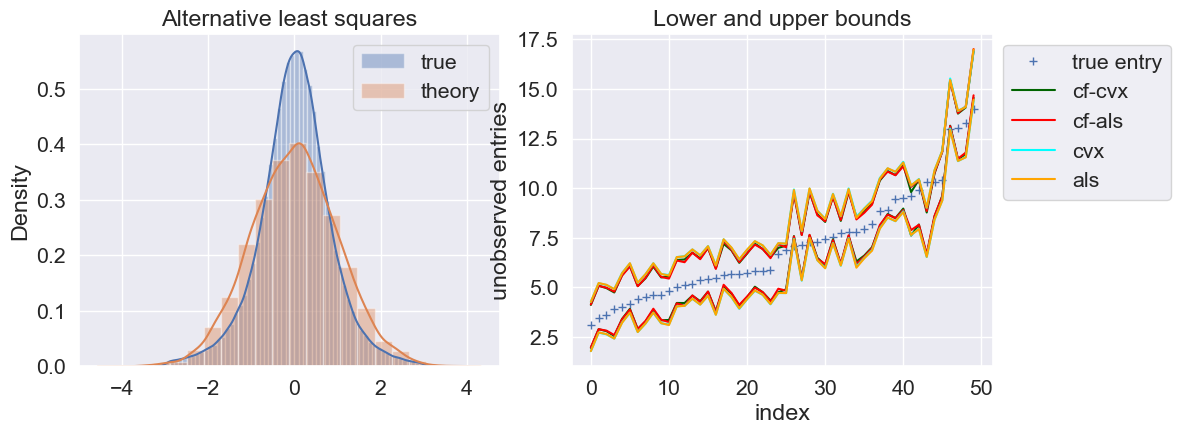

In [8]:
# plot
fig, ax = plt.subplots(ncols=2,figsize=(10,4))
fig.tight_layout(pad=0.6)
sns.set(font_scale = 1.4)

ind = np.random.choice(n0,50)
ind_seq = range(50)

sns.distplot(u_hat_als[np.abs(u_hat_als)<3], bins=60,kde=True, hist=True,label='true',ax=ax[0])
sns.distplot(u, bins=20,kde=True, hist=True,label='theory',ax=ax[0])
ax[0].legend(loc='best')
ax[0].set_title('Alternative least squares')

#         sns.distplot(u_hat_[np.abs(u_hat_)<10], bins=20,kde=True, hist=True,label='true',ax=ax[1])
#         sns.distplot(u, bins=20,kde=True, hist=True,label='theory',ax=ax[1])
#         ax[1].legend(loc='best')
#         ax[1].set_title('Convex')

#         sns.distplot(r[r<max(r)],bins=100,kde=True, hist=True,ax=ax[2])
#         ax[2].axvline(qvals, c='red')
#         ax[2].set_title('Histogram of scores')

m_ = m_star[ind]
sort_ord = m_.argsort()
ind = ind[sort_ord]
# compare results with oracle and estimated P
ax[1].plot(ind_seq,m_star[ind],'b+',label='true entry')
ax[1].plot(ind_seq,lo[ind],label=label1,c='darkgreen')
ax[1].plot(ind_seq,up[ind],c='darkgreen')
ax[1].plot(ind_seq,lo_hat[ind],label=label2,c='red')
ax[1].plot(ind_seq,up_hat[ind],c='red')
ax[1].plot(ind_seq,lo_uq_cvx[ind],label=label3,c='cyan')
ax[1].plot(ind_seq,up_uq_cvx[ind],c='cyan')
ax[1].plot(ind_seq,lo_uq_als[ind],label=label4,c='orange')
ax[1].plot(ind_seq,up_uq_als[ind],c='orange')
ax[1].legend(loc='best', bbox_to_anchor=(1, 1))
ax[1].set_xlabel('index')
ax[1].set_ylabel('unobserved entries')
ax[1].set_title('Lower and upper bounds')

plt.savefig('../plots/sales_plot_'+'_'+str(rk)+'_'+str(alpha)+'.pdf', bbox_inches='tight')

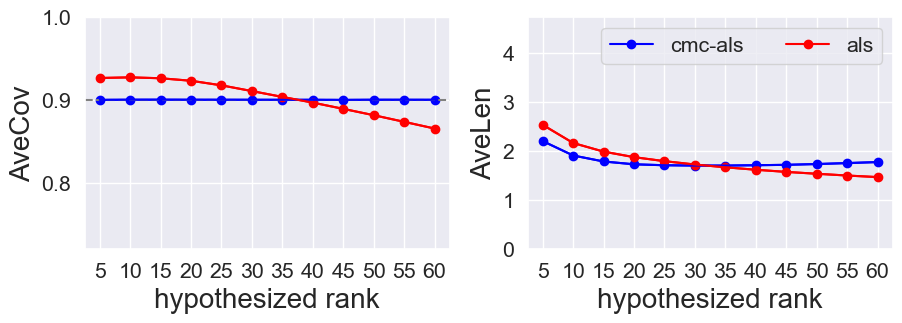

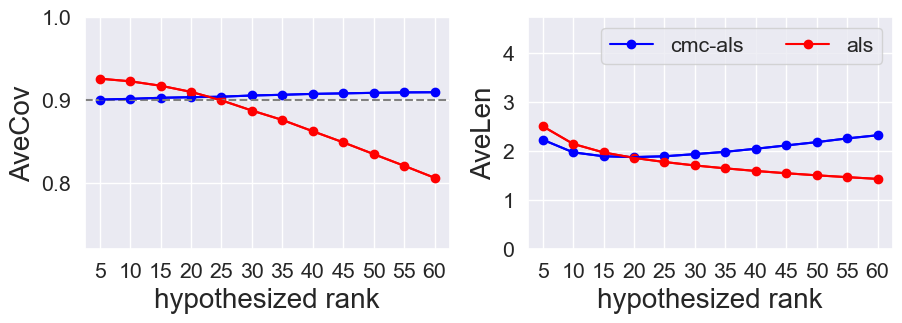

In [109]:
# plot
alpha = 0.1
repN = 100
data_ = 'sale'
full_exp = False
if full_exp:
    rk_seq = [5,15,25,35,45,55,65]
else:
    rk_seq = np.arange(5,61,5)

for d in [500]:
    d1 = d2 = d
    for alpha in [0.1]:
        for pr in [0.8]:
            for het in ['homo','rank1']:
                cov_conf = np.zeros(len(rk_seq))
                cov_conf_hat = np.zeros(len(rk_seq))
                cov_als = np.zeros(len(rk_seq))
                cov_cvx = np.zeros(len(rk_seq))
                len_conf = np.zeros(len(rk_seq))
                len_conf_hat = np.zeros(len(rk_seq))
                len_als = np.zeros(len(rk_seq))
                len_cvx = np.zeros(len(rk_seq))

                sd_cov_conf = np.zeros(len(rk_seq))
                sd_cov_conf_hat = np.zeros(len(rk_seq))
                sd_cov_als = np.zeros(len(rk_seq))
                sd_cov_cvx = np.zeros(len(rk_seq))
                sd_len_conf = np.zeros(len(rk_seq))
                sd_len_conf_hat = np.zeros(len(rk_seq))
                sd_len_als = np.zeros(len(rk_seq))
                sd_len_cvx = np.zeros(len(rk_seq))
                for i_rk in range(len(rk_seq)):
                    rk = rk_seq[i_rk]
                    file_dir1 = '../results/'+data_+'_cov_'+str(alpha)+'_'+het+'_'+str(pr)+'_'+str(rk)+'_'+str(full_exp)+'.csv'
                    file_dir2 = '../results/'+data_+'_len_'+str(alpha)+'_'+het+'_'+str(pr)+'_'+str(rk)+'_'+str(full_exp)+'.csv'
                    cov_df = pd.read_csv(file_dir1)
                    len_df = pd.read_csv(file_dir2)


                    label1 = 'cmc-'+base1
                    label2 = 'cmc-'+base2
                    label3 = 'cvx'
                    label4 = 'als'
                    
                    if full_exp:
                        nam_ = [label1]*repN + [label2]*repN + [label3]*repN + [label4]*repN
                    else:
                        nam_ = [label2]*repN + [label4]*repN
                    cov_df['approach'] = nam_
                    len_df['approach'] = nam_
                    
                    
                    cov_conf_hat[i_rk] = cov_df[cov_df['approach']==label2].mean(axis=0)[0]
                    cov_als[i_rk] = cov_df[cov_df['approach']==label4].mean(axis=0)[0]
                    sd_cov_conf_hat[i_rk] = cov_df[cov_df['approach']==label2].sem(axis=0)[0]
                    sd_cov_als[i_rk] = cov_df[cov_df['approach']==label4].sem(axis=0)[0]

                    len_conf_hat[i_rk] = len_df[len_df['approach']==label2].mean(axis=0)[0]
                    len_als[i_rk] = len_df[len_df['approach']==label4].mean(axis=0)[0]
                    sd_len_conf_hat[i_rk] = len_df[len_df['approach']==label2].sem(axis=0)[0]
                    sd_len_als[i_rk] = len_df[len_df['approach']==label4].sem(axis=0)[0]
            
                    if full_exp:
                        cov_conf[i_rk] = cov_df[cov_df['approach']==label1].mean(axis=0)[0]
                        cov_cvx[i_rk] = cov_df[cov_df['approach']==label3].mean(axis=0)[0]
                        sd_cov_conf[i_rk] = cov_df[cov_df['approach']==label1].sem(axis=0)[0]
                        sd_cov_cvx[i_rk] = cov_df[cov_df['approach']==label3].sem(axis=0)[0]
                        len_conf[i_rk] = len_df[len_df['approach']==label1].mean(axis=0)[0]
                        len_cvx[i_rk] = len_df[len_df['approach']==label3].mean(axis=0)[0]
                        sd_len_conf[i_rk] = len_df[len_df['approach']==label1].sem(axis=0)[0]
                        sd_len_cvx[i_rk] = len_df[len_df['approach']==label3].sem(axis=0)[0]
            
            


                fig, ax = plt.subplots(ncols=2,figsize=(9,3))     
                fig.tight_layout(pad=0.6)
                sns.set(font_scale = 1.4)

                col_seq=['orange','blue','green','red']

                ax[0].plot(range(len(rk_seq)), cov_conf_hat, marker='o', label=label2, c=col_seq[1])
                ax[0].errorbar(range(len(rk_seq)), cov_conf_hat, yerr = sd_cov_conf_hat, c=col_seq[1])
                ax[0].plot(range(len(rk_seq)), cov_als, marker='o', label=label4, c=col_seq[3])
                ax[0].errorbar(range(len(rk_seq)), cov_als, yerr = sd_cov_als, c=col_seq[3])
                if full_exp:
                    ax[0].plot(range(len(rk_seq)), cov_conf, marker='o', label=label1, c=col_seq[0])
                    ax[0].errorbar(range(len(rk_seq)), cov_conf, yerr = sd_cov_conf, c=col_seq[0])
                    ax[0].plot(range(len(rk_seq)), cov_cvx, marker='o', label=label3, c=col_seq[2])
                    ax[0].errorbar(range(len(rk_seq)), cov_cvx, yerr = sd_cov_cvx, c=col_seq[2])
                
                ax[0].set_ylim((0.8*(1-alpha),1))
                ax[0].set_xlim((-0.5,len(rk_seq)-0.5))
                ax[0].set_xlabel('hypothesized rank',fontsize=20)
                ax[0].set_ylabel('AveCov',fontsize=20)
                ax[0].set_xticks(np.arange(0,len(rk_seq),1),rk_seq)
                ax[0].axhline(y = 1-alpha, color = 'grey', linestyle = '--')


                ax[1].plot(range(len(rk_seq)), len_conf_hat, marker='o', label=label2, c=col_seq[1])
                ax[1].errorbar(range(len(rk_seq)), len_conf_hat, yerr = sd_len_conf_hat, c=col_seq[1])
                ax[1].plot(range(len(rk_seq)), len_als, marker='o', label=label4, c=col_seq[3])
                ax[1].errorbar(range(len(rk_seq)), len_als, yerr = sd_len_als, c=col_seq[3])
                if full_exp:
                    ax[1].plot(range(len(rk_seq)), len_conf, marker='o', label=label1, c=col_seq[0])
                    ax[1].errorbar(range(len(rk_seq)), len_conf, yerr = sd_len_conf, c=col_seq[0])
                    ax[1].plot(range(len(rk_seq)), len_cvx, marker='o', label=label3, c=col_seq[2])
                    ax[1].errorbar(range(len(rk_seq)), len_cvx, yerr = sd_len_cvx, c=col_seq[2])
                    
                ax[1].set_xticks(np.arange(0,len(rk_seq),1),rk_seq)
                ax[1].set_xlabel('hypothesized rank',fontsize=20)
                ax[1].set_ylabel('AveLen',fontsize=20)
                
                if full_exp:
                    ymax = max(len_conf)*1.5
                else:
                    ymax = max(len_conf_hat+len_als)/1
                    
                ax[1].set_ylim((0,ymax))
                ax[1].set_xlim((-0.5,len(rk_seq)-0.5))
                ax[1].legend(loc='best',ncol=2)

                plot_dir = '../plots/'+data_+'_rk_'+str(alpha)+'_'+het+'_'+str(pr)+'_'+str(full_exp)+'.pdf'
                plt.savefig(plot_dir, bbox_inches='tight')

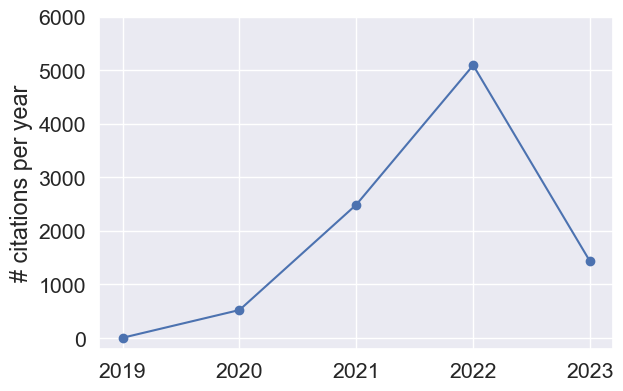

In [103]:
fig, ax = plt.subplots(figsize=(6,4))     
fig.tight_layout(pad=0.6)
sns.set(font_scale = 1.4)
cite = [6, 524, 2490, 5090, 1430]
year = range(2019,2024)
ax.plot(year, cite, 'bo-')
ax.set_ylabel('# citations per year')
ax.set_ylim((-200,6000))
plot_dir = '../plots/plot_simclr.pdf'
plt.savefig(plot_dir, bbox_inches='tight')